In [2]:
import sys
sys.path.append('./RECOTOOLS/')
# import project_metadata
from core import system_run, survey_metadata, run_collection, feature_collection
import datalibrary
import processor
import systems.pelisystem
import pandas as pd
from pandas_tools import *
import matplotlib.pyplot as plt
import numpy as np

survey_features = pd.read_csv("INTERMEDIATE/metadata_featurelist.csv")


In [8]:
# Load MuGrass
import sys

from mugrass.units import *
from mugrass.pixel_collection import *
from mugrass.muon_opacity import *

positions = []
n_good_pixels = []

def build_pixels_for_row(row):
    
    # Make new custom data frame
    sub_pixels = pd.DataFrame({})
    print("ROW = ", row)
    pixel_lookup = systems.pelisystem.load_system_lookup(row)
  
    positions.append(row["POS"])
    good_pix_count = 0
    pixellist = []
  
    #print(row["POS"],row["DATE"])
    # Loop over all possible pixels
   
    for pixel in systems.pelisystem.pixel_list:
        if len(pixel) > 2: continue
        pixelid = ','.join(map(str, pixel))   
        
        # Get our lookup from earlier
        fov  = pixel_lookup[pixelid.replace(",","")]
        print("FOV = ",fov)
        break       
        dfpixel = {}        
        dfpixel["x"]         = row["POS"]*m
        dfpixel["y"] = 0*m  
        thyzoffset = 0.0
        dfpixel["z"]         = 0.0
        
        # negative because FOV lookup table is rotated 180 degrees from real system (i.e. back of system --> front)
        dfpixel["thxz"]      = -fov["thxz"] 
        dfpixel["thyz"]      = fov["thyz"] + thyzoffset
        dfpixel["thrz"]      = fov["thrz"] 
        dfpixel["exposure"]     = row["exposure"]
        dfpixel["os_exposure"] = row["os_exposure"]
        dfpixel["rate"]      = row[f"pixel:{pixelid}"]
        dfpixel["osrate"]    = row[f"ospixel:{pixelid}"]
        dfpixel["trans"]     = row[f"pixel_trans:{pixelid}"]
        dfpixel["transerr"]     = row[f"pixel_transerr:{pixelid}"]
  
        xpos=dfpixel["x"]/m
        if row[f"pixel_trans:{pixelid}"] > 1: 
            print("Skipping pixel because of > 1", pixelid, row[f"pixel_trans:{pixelid}"], row[f"pixel:{pixelid}"], row[f"ospixel_rate:{pixelid}"], row[f"pixel_trans:{pixelid}"], row["rate"], row["os_rate"], row["os_exposure"])
            continue
        if row[f"pixel_trans:{pixelid}"] <= 0: 
            print(f"skipping pixel {pixelid} at x={xpos} because of trans < 0")
            continue
            
    
        dfpixel["pixel"]     = fov["pixel"]
        dfpixel["type"]      = fov["type"]

        dfpixel["spreadxz"]  = fov["spreadxz"]
        dfpixel["spreadyz"]  = fov["spreadyz"]

        # negative because FOV lookup table is rotated 180 degrees from real system (i.e. back of system --> front)
        dfpixel["fov_anglexz"] = -np.array(fov["fov_anglexz"])
        dfpixel["fov_angleyz"] = np.array(fov["fov_angleyz"])
        dfpixel["fov_value"]   = np.array(fov["fov_value"])
        dfpixel["combo"] = pixelid
        pixellist.append(dfpixel)
     
        
    if (len(pixellist) == 0): return None
    #print(len(pixellist))
    n_good_pixels.append(good_pix_count)
    data = {}
    for col in pixellist[0]:
        data[col] = []
    for val in pixellist:
        for col in pixellist[0]:
            data[col].append(val[col])


    sub_pixels = pd.DataFrame(data=data)
    #print("FOV", sub_pixels["fov_value"][0])
    return sub_pixels

def build_pixels_from_features(features):
    # Make new custom data frame for all
    top_pixels = pd.DataFrame({})
 
    # Make a collection of pixels for each run
    for index, row in features.iterrows():
        sub_pixels = build_pixels_for_row(row)
        
        # Flatten the top pixels
        top_pixels = pd.concat([top_pixels, sub_pixels], ignore_index=True, sort=False)

    run_config = {}
    final_pixels = pixel_collection(pixel_df=top_pixels,
                                    config_dict=run_config )
    
    return final_pixels

pixels = build_pixels_from_features(survey_features)

pixels.df["opacity"] = opacity_from_transmission(pixels.df["trans"],pixels.df["thrz"])

pixels.df["opacityhi"] = opacity_from_transmission(pixels.df["trans"]+pixels.df["transerr"],pixels.df["thrz"])
pixels.df["opacitylo"] = opacity_from_transmission(pixels.df["trans"]-pixels.df["transerr"],pixels.df["thrz"])
pixels.df["opacityerr"] = np.abs(pixels.df["opacityhi"]-pixels.df["opacitylo"])/2.0

# Use this code to save a reduced version of the pixel frame that only covers a particular ROI

# pixels_roi0=pixels.df.loc[(pixels.df.x <= 40*m)]

# pixels_roi0.reset_index(drop=True, inplace=True)

# pixels_roi0_collection=pixel_collection(pixel_df=pixels_roi0,config_dict={})       

# pixels_roi0_collection.Write("./pixel_dataframe_roi0.pxl")

pixels.Write("./pixel_dataframe.pxl")

pixels.df.to_csv("./pixel_dataframe_readable.csv")

plt.scatter(x=pixels.df["x"]/m,y=pixels.df["trans"])
plt.xlabel("Position [m]")
plt.ylabel("Transmission")
plt.show()

plt.scatter(x=pixels.df["x"]/m,y=pixels.df["opacity"]/(g/cm2))
plt.xlabel("Position [m]")
plt.ylabel("Estimated Opacity [g/cm3]")
plt.show()


FOV =  {'thxz': 0.3917717389668838, 'thyz': -0.08693704899595331, 'thrz': 0.5178570915280217, 'pixel': None, 'type': 'IntegralXZYZPixel', 'spreadxz': 0.27471471730285246, 'spreadyz': 0.32778480524367015, 'fov_anglexz': [0.045454545454545414, 0.045454545454545414, 0.045454545454545414, 0.045454545454545414, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.07575757575757569, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619, 0.10606060606060619,

KeyError: 'trans'

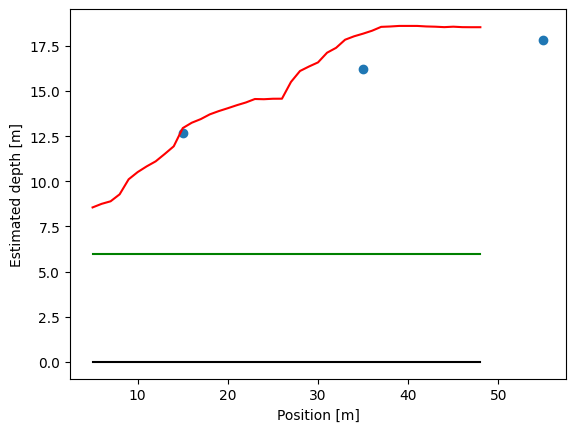

In [5]:
from gistools import *

# Baseline distance of points to average in m
av_base=20

dtm_offset = 0

tunnel_height=6

pixels.df["length_estimate"]=pixels.df["opacity"]/(2.65*(g/cm3))
pixels.df["depth_estimate"]=(0.5*((pixels.df["length_estimate"]*np.cos(pixels.df["thxz"]))+(pixels.df["length_estimate"]*np.cos(pixels.df["thyz"]))))


x_min=int(pixels.df["x"].min()/m)
x_max=int(pixels.df["x"].max()/m)


d_vec=np.zeros(len(range(x_min,x_max,av_base)))
x_vec=np.zeros(len(range(x_min,x_max,av_base)))

j=0
for xpos in range(x_min,x_max,av_base):
    d_vec[j]=((pixels.df.loc[(pixels.df.x/m>xpos) & (pixels.df.x/m<=xpos+20),"depth_estimate"]).mean())/1000
    x_vec[j]=xpos+av_base/2
    j=j+1


plt.scatter(x=x_vec,y=d_vec+tunnel_height)
plt.xlabel("Position [m]")
plt.ylabel("Estimated depth [m]")

gis_model = pd.read_csv("GIS/generated_gis_model_copy.csv")

gis_model=gis_model.loc[(gis_model.X>=x_min-np.abs(dtm_offset)) & (gis_model.X<=x_max+np.abs(dtm_offset))]

gis_model.reset_index(drop=True, inplace=True)

crown=get_gis_crown(gis_model)
plt.plot(crown.X+dtm_offset, crown.DTM_gradcorr,'r')

# Add tunnel lines to plot
plt.plot(np.linspace(x_min,x_max,av_base), tunnel_height*np.ones(av_base),'g')
plt.plot(np.linspace(x_min,x_max,av_base), tunnel_height*np.zeros(av_base),'k')
plt.show()

